In [1]:
# importing relevant libraries
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import pandas as pd
import re

In [2]:
# downloading the IMDB reviews dataset form tensorflow datasets and splitting the data
(train_ds, test_ds), ds_info = tfds.load('imdb_reviews', split = (tfds.Split.TRAIN, tfds.Split.TEST), as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete8SRO33/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete8SRO33/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete8SRO33/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
# convert the dataset into a pandas dataframe
train_df = tfds.as_dataframe(train_ds, ds_info=ds_info)
test_df = tfds.as_dataframe(test_ds, ds_info=ds_info)

In [4]:
regex = re.compile(r'<[^>]+>')

# removes all html tags with `<>`
def removeHTMLTags(string):
  return regex.sub('', string)

# decoding the byte strings to strings and removing html tags for all text data in both the train and test dataframes
for index, row in train_df.iterrows():
  if type(train_df.loc[index, 'text']) != str:
    train_df.loc[index, 'text'] = removeHTMLTags(train_df.loc[index, 'text'].decode())

for index, row in test_df.iterrows():
  if type(test_df.loc[index, 'text']) != str:
    test_df.loc[index, 'text'] = removeHTMLTags(test_df.loc[index, 'text'].decode())

In [5]:
# splitting the test and train dataframes according to the predictor text variables (X_train and X_test) and the variable to be predicted (Y_test and Y_train)
X_train = pd.DataFrame(train_df.text)
Y_train = pd.DataFrame(train_df.label)

X_test = pd.DataFrame(test_df.text)
Y_test = pd.DataFrame(test_df.label)

In [6]:
# defining the text input embedder
embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"

# the input Keras layer from hub
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

# creating a new model and adding it's input layer
model = tf.keras.models.Sequential()
model.add(hub_layer)

# adding hidden layers
model.add(tf.keras.layers.Dropout(0.6))


# adding the putput layer
model.add(tf.keras.layers.Dense(1, activation='sigmoid', name='output'))

# displaying a summary of the constructed tensorflow model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 output (Dense)              (None, 1)                 129       
                                                                 
Total params: 124,642,817
Trainable params: 124,642,817
Non-trainable params: 0
_________________________________________________________________


In [7]:
# compile the model by setting relevant metrics using the Adam optimizer with a low learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), 
              loss='binary_crossentropy', 
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')]
)

In [8]:
# fit and store the compiled model with the train data for 50 epochs with a larger batch size of 64 (default 32)
history = model.fit(X_train, Y_train, validation_split= 0.25, epochs=20, batch_size = 32)

Epoch 1/20
586/586 [==============================] - 49s 78ms/step - loss: 0.6716 - accuracy: 0.5918 - precision: 0.5914 - recall: 0.5862 - val_loss: 0.6002 - val_accuracy: 0.7682 - val_precision: 0.7486 - val_recall: 0.8139
Epoch 2/20
586/586 [==============================] - 45s 77ms/step - loss: 0.5810 - accuracy: 0.7171 - precision: 0.7131 - recall: 0.7235 - val_loss: 0.5338 - val_accuracy: 0.8048 - val_precision: 0.8076 - val_recall: 0.8050
Epoch 3/20
586/586 [==============================] - 45s 77ms/step - loss: 0.5078 - accuracy: 0.7877 - precision: 0.7846 - recall: 0.7915 - val_loss: 0.4775 - val_accuracy: 0.8230 - val_precision: 0.8346 - val_recall: 0.8098
Epoch 4/20
586/586 [==============================] - 45s 78ms/step - loss: 0.4462 - accuracy: 0.8311 - precision: 0.8327 - recall: 0.8273 - val_loss: 0.4308 - val_accuracy: 0.8371 - val_precision: 0.8278 - val_recall: 0.8551
Epoch 5/20
586/586 [==============================] - 45s 76ms/step - loss: 0.3919 - accuracy: 0

In [9]:
# Evaluate the accuracy of the trained model 
eval_values = model.evaluate(X_test, Y_test)

782/782 [==============================] - 6s 8ms/step - loss: 0.2968 - accuracy: 0.8749 - precision: 0.8766 - recall: 0.8727


In [10]:
# predict the sentiment of the X values in the test data
Y_predicted = model.predict(X_test.text.values.tolist()).flatten()
Y_predicted = np.where(Y_predicted > (max(Y_predicted) + min(Y_predicted))/2, 1, 0)

782/782 [==============================] - 5s 7ms/step


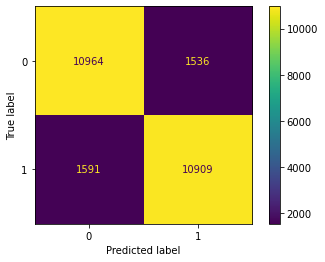

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# create and plot a confusion matrix according to the predicted Y values in comparison to the ground truth
cm = confusion_matrix(Y_test, Y_predicted)
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [12]:
# Get True Negative, False Negative, False Positive and True Positive Values from the confusion matrix
TN = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TP = cm[1][1]

# Calculate and print metrics that determine how good the model is
accuracy = (TP + TN) / float(TP + TN + FP + FN)
error = (FP + FN) / float(TP + TN + FP + FN)
sensitivity = TP / float(FN + TP)
specificity = TN / float(TN + FP)
false_positive_rate = FP / float(TN + FP)
precision = TP / float(TP + FP)
fscore = TP/float(TP + (FP + FN)/2)

print( 
      """
      Accuracy:             {}
      Error:                {}
      Sensitivity:          {}
      Specificity:          {}
      False Positive Rate:  {}
      Precision:            {}
      F-score:              {}
      """.format(round(accuracy, 3), round(error, 3), round(sensitivity, 3), round(specificity, 3), round(false_positive_rate, 3), round(precision, 3), round(fscore, 3)))


      Accuracy:             0.875
      Error:                0.125
      Sensitivity:          0.877
      Specificity:          0.873
      False Positive Rate:  0.127
      Precision:            0.873
      F-score:              0.875
      


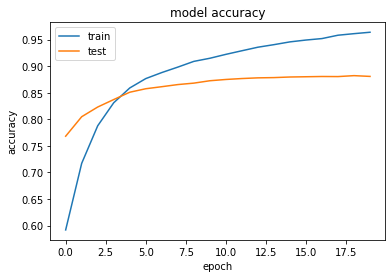

In [13]:
import matplotlib.pyplot as plt

# plotting the history for accuracy of the model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

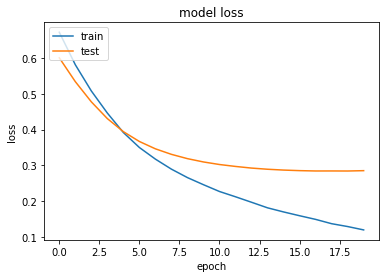

In [14]:
# plotting history for loss of the model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()